In [790]:
# This is a notebook to analyse dataset for internet customers.

In [791]:
# Local all required packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [792]:
# Add function definitions
def radarplot(df, norm_max=False):
    df = df.copy()
    if norm_max:
        df /= df.max()

    angles = np.linspace(0, 2 * np.pi, len(df.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the plot

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    for i in df.index:
        stats = df.loc[i, :].values
        stats = np.concatenate((stats, [stats[0]]))  # close the plot
        ax.plot(angles, stats, 'o-', linewidth=2, label=i)
        ax.fill(angles, stats, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    columns = list(df.columns) + list(df.columns[:1])
    # print((angles * 180 / np.pi).shape, len(columns))
    ax.set_thetagrids(angles * 180 / np.pi, columns)
    ax.grid(True)
    return ax

In [793]:
# Load the dataset
data = pd.read_csv("BP_DS_Challenge.csv")
data[:5]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [794]:
# Dataset cleaning
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0)
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
data = data.drop(columns="customerID")

In [795]:
pd.concat([data.dtypes.to_frame().rename(columns={0: "type"}), data.nunique().to_frame().rename(columns={0: "unique_num"})], axis=1)

,type,unique_num
gender,object,2
SeniorCitizen,object,2
Partner,object,2
Dependents,object,2
tenure,int64,73
PhoneService,object,2
MultipleLines,object,3
InternetService,object,3
OnlineSecurity,object,3
OnlineBackup,object,3


In [796]:
# Extract the independent variables and save as array in X
X = data.iloc[:,:-1].values
pd.DataFrame(X[:1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85


In [797]:
# Extract the dependent variable and save as array in Y
Y = data.iloc[:,-1].values
pd.DataFrame(Y[:1])

,0
0,No


In [798]:
# Encode the two-value columns using LabelEncoding and the multi-value columns using one hot encoder
LE1 = LabelEncoder()
multi_value_categorical = []
for i in range(data.shape[1]-1):
    col_type = str(data.dtypes[i])
    col_name = str(data.columns[i])
    col_unique_values = str(data.nunique()[i])       
    print(str(i) + " " +col_type + " " + col_name + " " + col_unique_values)
    if col_type == 'object':
        if col_unique_values == '2':
            X[:,i] = np.array(LE1.fit_transform(X[:,i]))
        else:
            multi_value_categorical.append(i)
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[6, 7, 8, 9, 10, 11, 12, 13, 14, 16])],remainder="passthrough")
X = np.array(ct.fit_transform(X))
Y[:] = np.array(LE1.fit_transform(Y[:]))

0 object gender 2
1 object SeniorCitizen 2
2 object Partner 2
3 object Dependents 2
4 int64 tenure 73
5 object PhoneService 2
6 object MultipleLines 3
7 object InternetService 3
8 object OnlineSecurity 3
9 object OnlineBackup 3
10 object DeviceProtection 3
11 object TechSupport 3
12 object StreamingTV 3
13 object StreamingMovies 3
14 object Contract 3
15 object PaperlessBilling 2
16 object PaymentMethod 4
17 float64 MonthlyCharges 1585
18 float64 TotalCharges 6531


In [799]:
pd.DataFrame(X[:1])

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0,0,1,0,1,0,1,29.85,29.85


In [800]:
# Apply feature selection. This step significantly improves the results:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = sel.fit_transform(X)

# ANOVA feature selection for numeric input and categorical output
#from sklearn.datasets import make_classification
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif
# define feature selection
#fs = SelectKBest(score_func=f_classif, k=30)
# apply feature selection
#X = fs.fit_transform(X, Y)
#print(X.shape)

In [801]:
pd.DataFrame(X[:1])

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0,1,0,1,1,29.85,29.85


In [802]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [803]:
# Normalise the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [804]:
ann = tf.keras.models.Sequential()

In [805]:
ann.add(tf.keras.layers.Dense(units=50,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [806]:
optimizer = tf.keras.optimizers.SGD()

In [807]:
ann.compile(optimizer, loss="mse", metrics=["mae", "acc"])

In [ ]:
history = ann.fit(X_train,Y_train,batch_size=32,epochs = 200)

Epoch 1/200
177/177 [==============================] - 1s 2ms/step - loss: 0.1964 - mae: 0.3836 - acc: 0.6979
Epoch 2/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1624 - mae: 0.3299 - acc: 0.7547
Epoch 3/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1544 - mae: 0.3150 - acc: 0.7696
Epoch 4/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1501 - mae: 0.3068 - acc: 0.7760
Epoch 5/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1474 - mae: 0.3025 - acc: 0.7872
Epoch 6/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1456 - mae: 0.2978 - acc: 0.7890
Epoch 7/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1441 - mae: 0.2953 - acc: 0.7911
Epoch 8/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1430 - mae: 0.2932 - acc: 0.7953
Epoch 9/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1421 - mae: 0.2905 - acc: 0.7953
Epoch 10/2

In [ ]:
lreg = LogisticRegression(random_state = 0)
lreg.fit(X_train, Y_train)

In [ ]:
ypred = {}
ypred["ANN"] = ann.predict(X_test)
ypred["Regression"] = [x[1] for x in lreg.predict_proba(X_test)]

In [ ]:
results = {}
for method, predictions in ypred.items():
    print(method)
    fpr, tpr, _ = metrics.roc_curve(Y_test, predictions)
    auc = metrics.roc_auc_score(Y_test, predictions)
    plt.plot(fpr,tpr,label=method + ", auc="+str(auc))
    results[method] = [str(auc)]
plt.legend(loc=4)
plt.show()

In [ ]:
for method, predictions in ypred.items():
    preds = []
    for x in predictions:
        if x <= 0.5:
            preds.append(0.0)
        else:
            preds.append(1.0)
    acc = accuracy_score(Y_test, preds )
    prec = precision_score(Y_test, preds )
    rec = recall_score(Y_test, preds )
    f1 = f1_score(Y_test, preds )
    f2 = fbeta_score(Y_test, preds, beta=2.0)
    results[method] = np.concatenate((results[method], [acc, prec, rec, f1, f2]))

In [ ]:
results_df = pd.DataFrame(results, index=["auc", "acc", "prec", "rec", "f1", "f2"]).transpose()

In [787]:
results_df = results_df.apply(pd.to_numeric)

In [788]:
results_df

,auc,acc,prec,rec,f1,f2
ANN,0.817922,0.786373,0.605016,0.524457,0.561863,0.538805
Regression,0.827948,0.804826,0.653465,0.538043,0.590164,0.557746


<PolarAxesSubplot:>

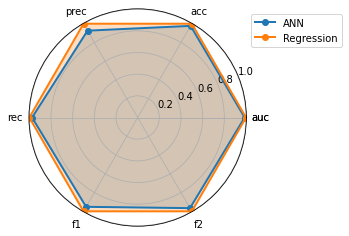

In [789]:
# Visualise the offline evaluation results
radarplot(results_df, norm_max=True)